In [9]:
#샘플 데이터베이스 구축
import os
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# ---------------------------
# 1. CLIP 모델 불러오기
# ---------------------------
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# ---------------------------
# 2. 이미지 임베딩 추출 함수
# ---------------------------
def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    return features.numpy()

# ---------------------------
# 3. 데이터셋 폴더 설정
# ---------------------------
gan_dataset_path = "./sample_data/gan_sample_dataset"
furniture_dataset_path = "./sample_data/recomm_dataset"

# ---------------------------
# 4. 임베딩 및 경로 추출 함수
"""
dataset_path: 데이터셋 경로
output_embeddings: 추출된 임베딩을 저장할 파일 경로
output_paths: 이미지 경로를 저장할 파일 경로
image_paths: 데이터셋 내 모든 이미지 파일 경로를  리스트로 저장
xtract_features(path): 각 이미지의 특징 벡터를 추출
embeddings.append(features): 추출된 특징 벡터를 리스트에 추가
np.save(output_embeddings, np.vstack(embeddings)): 임베딩을 .npy 파일로 저장
np.save(output_paths, np.array(image_paths)): 이미지 경로를 .npy 파일로 저장
"""
# ---------------------------
def build_dataset_embeddings(dataset_path, output_embeddings, output_paths):
    if not os.path.isdir(dataset_path):
        print(f"❌ Dataset folder '{dataset_path}' not found.")
        return
    image_paths = [os.path.join(dataset_path, fname) 
                   for fname in os.listdir(dataset_path) 
                   if fname.lower().endswith(('png', 'jpg', 'jpeg'))]

    if not image_paths:
        print(f"❌ {dataset_path}에 이미지가 없습니다.")
        return

    print(f"🖼️ {dataset_path}에서 {len(image_paths)}개 이미지 발견")

    embeddings = []
    for path in image_paths:
        try:
            features = extract_features(path)
            embeddings.append(features)
            print(f"✅ {os.path.basename(path)} 임베딩 추출 완료")
        except Exception as e:
            print(f"❌ {os.path.basename(path)} 임베딩 추출 실패: {e}")

    # .npy 파일로 저장
    np.save(output_embeddings, np.vstack(embeddings))
    np.save(output_paths, np.array(image_paths))
    print(f"💾 {output_embeddings} 및 {output_paths} 저장 완료!\n")

# ---------------------------
# 5. GAN 생성 이미지셋 임베딩 생성 및 저장

# 임베딩 저장 폴더
embedding_dir = "embeddings"
os.makedirs(embedding_dir, exist_ok=True)  # 폴더가 없으면 생성
# ---------------------------
"""
gan_dataset_path: GAN 생성 이미지셋 경로
"gan_embeddings.npy": GAN 생성 이미지셋 임베딩 저장 파일 경로
"gan_image_paths.npy": GAN 생성 이미지셋 이미지 경로 저장 파일 경로
"""
# ---------------------------
build_dataset_embeddings(
    gan_dataset_path,
    os.path.join(embedding_dir, "gan_embeddings.npy"),
    os.path.join(embedding_dir, "gan_image_paths.npy")
)

# ---------------------------
# 6. 추천 가구 이미지셋 임베딩 생성 및 저장
"""
furniture_dataset_path: 가구 이미지셋 경로
"sample_furniture_embeddings.npy": 가구 이미지셋 임베딩 저장 파일 경로
"sample_furniture_image_paths.npy": 가구 생성 이미지셋 이미지 경로 저장 파일 경로
"""
# ---------------------------
build_dataset_embeddings(
    furniture_dataset_path,
    os.path.join(embedding_dir, "sample_furniture_embeddings.npy"),
    os.path.join(embedding_dir, "sample_furniture_image_paths.npy")
)

print("🎉 샘플 데이터베이스 구축 완료!")


🖼️ ./sample_data/gan_sample_dataset에서 4개 이미지 발견
✅ Chair--250-_jpg.rf.85538c3f154c565e09debef01a25ca4d.jpg 임베딩 추출 완료
✅ Sofa--375-_jpg.rf.5c78d0f3f62594296e90a00bc5a65c8d.jpg 임베딩 추출 완료
✅ Table--201-_jpg.rf.264f2a192e62dcb448d881f7cb08dd6a.jpg 임베딩 추출 완료
✅ Table--218-_jpg.rf.5651c3ba563e4adf6e00f2779c2c5b60.jpg 임베딩 추출 완료
💾 embeddings\gan_embeddings.npy 및 embeddings\gan_image_paths.npy 저장 완료!

🖼️ ./sample_data/recomm_dataset에서 4개 이미지 발견
✅ image_126.jpeg 임베딩 추출 완료
✅ image_414.jpeg 임베딩 추출 완료
✅ image_78.jpeg 임베딩 추출 완료
✅ image_9.jpeg 임베딩 추출 완료
💾 embeddings\sample_furniture_embeddings.npy 및 embeddings\sample_furniture_image_paths.npy 저장 완료!

🎉 샘플 데이터베이스 구축 완료!


In [8]:
import os
print("현재 실행 디렉토리:", os.getcwd())


현재 실행 디렉토리: c:\Users\LG\elice\sketch2furnish\matching


In [ ]:
#임베딩 데베, 이미지 경로 데베 형태 확인
print(np.load('sample_furniture_embeddings.npy').shape)
print(np.load('sample_furniture_image_paths.npy').shape)
print(np.load('gan_embeddings.npy').shape)
print(np.load('gan_image_paths.npy').shape)

(4, 512)
(4,)
(4, 512)
(4,)


In [ ]:
#데베 로그 및 확인
import numpy as np

# ---------------------------
# 1. 데이터베이스 로드
"""
gan_embeddings: GAN 생성 이미지 임베딩 데이터
gan_image_paths: GAN 생성 이미지 경로 데이터
sample_furniture_embeddings: 추천 가구 이미지 임베딩 데이터
sample_furniture_image_paths: 추천 가구 이미지 경로 데이터

"""
# ---------------------------
gan_embeddings = np.load('gan_embeddings.npy')
gan_image_paths = np.load('gan_image_paths.npy')

furniture_embeddings = np.load('sample_furniture_embeddings.npy')
furniture_image_paths = np.load('sample_furniture_image_paths.npy')

# ---------------------------
# 2. 데이터 크기 출력
# ---------------------------
print(f"GAN 생성 이미지 임베딩 크기: {gan_embeddings.shape}")
print(f"GAN 생성 이미지 경로 수: {len(gan_image_paths)}")

print(f"추천 가구 이미지 임베딩 크기: {furniture_embeddings.shape}")
print(f"추천 가구 이미지 경로 수: {len(furniture_image_paths)}")

# ---------------------------
# 3. 샘플 데이터 출력
# ---------------------------
print("\n📂 샘플 GAN 이미지 경로:")
for path in gan_image_paths[:4]:
    print(path)

print("\n📂 샘플 추천 가구 이미지 경로:")
for path in furniture_image_paths[:4]:
    print(path)


GAN 생성 이미지 임베딩 크기: (4, 512)
GAN 생성 이미지 경로 수: 4
추천 가구 이미지 임베딩 크기: (4, 512)
추천 가구 이미지 경로 수: 4

📂 샘플 GAN 이미지 경로:
./gan_sample_dataset\Chair--250-_jpg.rf.85538c3f154c565e09debef01a25ca4d.jpg
./gan_sample_dataset\Sofa--375-_jpg.rf.5c78d0f3f62594296e90a00bc5a65c8d.jpg
./gan_sample_dataset\Table--201-_jpg.rf.264f2a192e62dcb448d881f7cb08dd6a.jpg
./gan_sample_dataset\Table--218-_jpg.rf.5651c3ba563e4adf6e00f2779c2c5b60.jpg

📂 샘플 추천 가구 이미지 경로:
./recomm_dataset\image_126.jpeg
./recomm_dataset\image_414.jpeg
./recomm_dataset\image_78.jpeg
./recomm_dataset\image_9.jpeg


✅ GAN 생성 이미지 수: 4개
✅ 추천 가구 이미지 수: 4개

🎨 [GAN generated images: ./gan_sample_dataset\Chair--250-_jpg.rf.85538c3f154c565e09debef01a25ca4d.jpg] Recommend similar furniture:
  🔹 recommendation 1: ./recomm_dataset\image_9.jpeg | Similarity: 0.8190
  🔹 recommendation 2: ./recomm_dataset\image_126.jpeg | Similarity: 0.7456
  🔹 recommendation 3: ./recomm_dataset\image_78.jpeg | Similarity: 0.7296


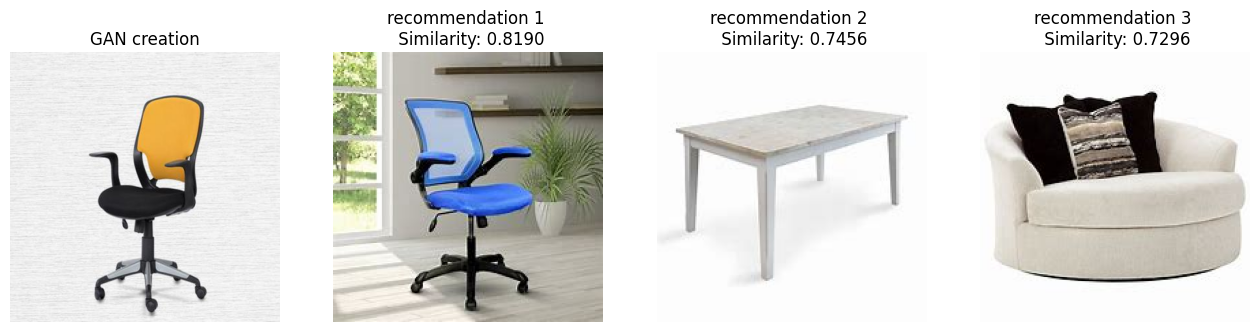


🎨 [GAN generated images: ./gan_sample_dataset\Sofa--375-_jpg.rf.5c78d0f3f62594296e90a00bc5a65c8d.jpg] Recommend similar furniture:
  🔹 recommendation 1: ./recomm_dataset\image_78.jpeg | Similarity: 0.8250
  🔹 recommendation 2: ./recomm_dataset\image_126.jpeg | Similarity: 0.8119
  🔹 recommendation 3: ./recomm_dataset\image_9.jpeg | Similarity: 0.7843


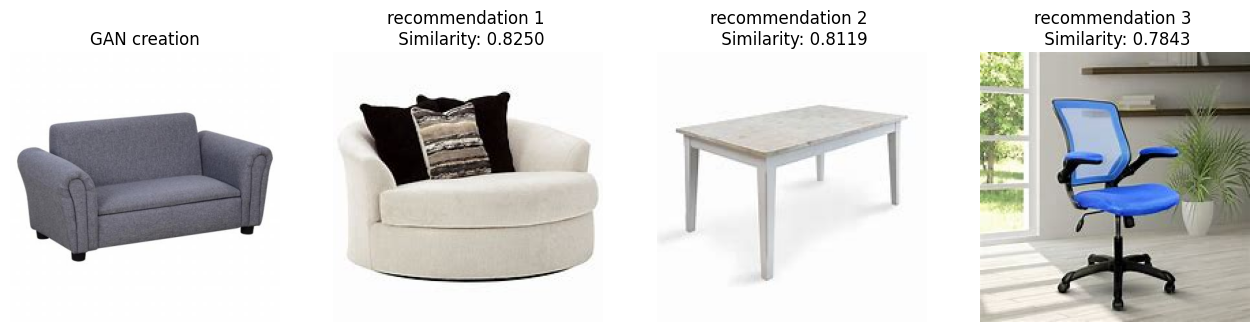


🎨 [GAN generated images: ./gan_sample_dataset\Table--201-_jpg.rf.264f2a192e62dcb448d881f7cb08dd6a.jpg] Recommend similar furniture:
  🔹 recommendation 1: ./recomm_dataset\image_414.jpeg | Similarity: 0.9182
  🔹 recommendation 2: ./recomm_dataset\image_126.jpeg | Similarity: 0.9162
  🔹 recommendation 3: ./recomm_dataset\image_9.jpeg | Similarity: 0.7845


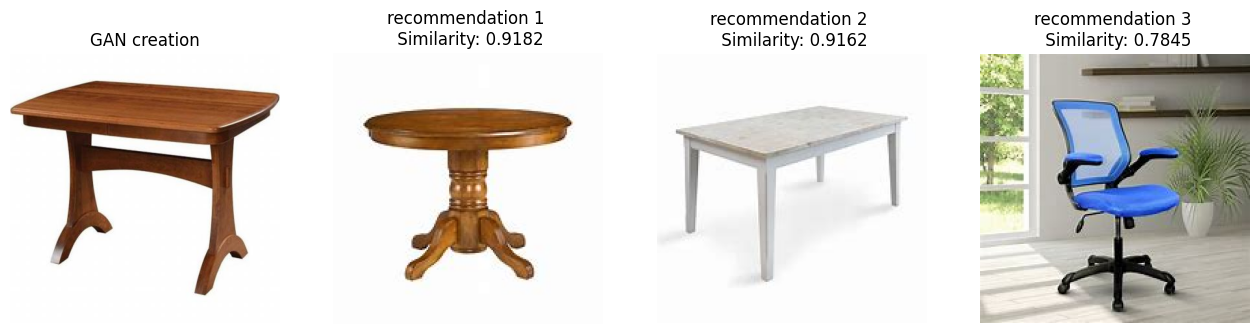


🎨 [GAN generated images: ./gan_sample_dataset\Table--218-_jpg.rf.5651c3ba563e4adf6e00f2779c2c5b60.jpg] Recommend similar furniture:
  🔹 recommendation 1: ./recomm_dataset\image_9.jpeg | Similarity: 0.7986
  🔹 recommendation 2: ./recomm_dataset\image_126.jpeg | Similarity: 0.7958
  🔹 recommendation 3: ./recomm_dataset\image_78.jpeg | Similarity: 0.6983


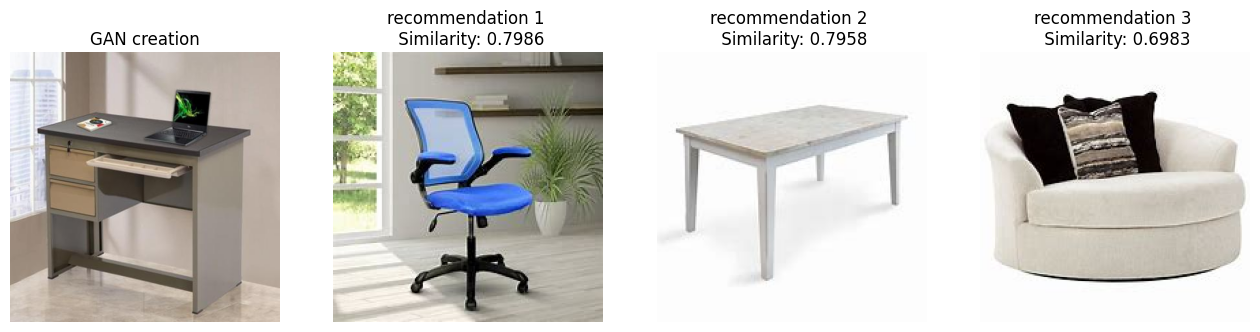

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# 1. 데이터베이스 로드
# ---------------------------
gan_embeddings = np.load('gan_embeddings.npy')
gan_image_paths = np.load('gan_image_paths.npy')

furniture_embeddings = np.load('sample_furniture_embeddings.npy')
furniture_image_paths = np.load('sample_furniture_image_paths.npy')

print(f"✅ GAN 생성 이미지 수: {len(gan_image_paths)}개")
print(f"✅ 추천 가구 이미지 수: {len(furniture_image_paths)}개")

# ---------------------------
# 2. 코사인 유사도 계산
# ---------------------------
similarities = cosine_similarity(gan_embeddings, furniture_embeddings)

# ---------------------------
# 3. 상위 N개 유사 추천 및 시각화
# ---------------------------
def display_recommendations(gan_image_path, recommended_paths, scores):
    fig, axs = plt.subplots(1, len(recommended_paths) + 1, figsize=(16, 4))
    
    # GAN 생성 이미지 표시
    axs[0].imshow(Image.open(gan_image_path))
    axs[0].set_title("GAN creation")
    axs[0].axis('off')
    
    # 추천된 유사 가구 이미지 표시
    for i, (path, score) in enumerate(zip(recommended_paths, scores)):
        axs[i+1].imshow(Image.open(path))
        axs[i+1].set_title(f"recommendation {i+1} \n Similarity: {score:.4f}")
        axs[i+1].axis('off')
    
    plt.show()

# ---------------------------
# 4. 각 GAN 이미지에 대해 상위 3개 추천
# ---------------------------
top_n = 3

for i, gan_path in enumerate(gan_image_paths):
    # 유사도 상위 3개 인덱스
    top_indices = similarities[i].argsort()[::-1][:top_n]
    
    recommended_paths = [furniture_image_paths[idx] for idx in top_indices]
    recommended_scores = [similarities[i][idx] for idx in top_indices]

    print(f"\n🎨 [GAN generated images: {gan_path}] Recommend similar furniture:")
    for j, (path, score) in enumerate(zip(recommended_paths, recommended_scores)):
        print(f"  🔹 recommendation {j+1}: {path} | Similarity: {score:.4f}")
    
    # 시각화
    display_recommendations(gan_path, recommended_paths, recommended_scores)
